In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import fitsio as ft
import healpy as hp
import numpy as np
from   glob import glob
import pandas as pd
import seaborn as sns

# PATHS to my storage
# mehdi  @ cori
# rezaie @ OU iMac
HOME    = os.getenv('HOME')
USER    = os.getenv('USER')
sys.path.append(HOME + '/github/SYSNet/src')
from utils import split2Kfolds, split2KfoldsSpatially
dirs    = dict(rezaie='/Volumes/TimeMachine/data/', mehdi='/global/cscratch1/sd/mehdi/')
scratch = dirs[USER]
print('home is {}'.format(HOME))

camb is not installed!
home is /Users/rezaie


In [10]:
import utils as ut

In [30]:
ls $scratch/eboss/sysmaps

SDSS_WISE_imageprop_nside512.fits  eBOSS_eboss25/
SDSSimageprop_Nside512.fits        eBOSS_res1024
ccdfiles/                          eBOSS_res256
eBOSS_eboss21/                     eboss256.tar
eBOSS_eboss22/                     eboss_nobs/
eBOSS_eboss23/                     eboss_nobs.tar.gz


In [32]:
sdsswise = ft.read(scratch +'/eboss/sysmaps/SDSS_WISE_imageprop_nside512.fits', lower=True)
sdsswise.dtype.names, sdsswise.size

(('nran',
  'sky_g',
  'sky_r',
  'sky_i',
  'sky_z',
  'airmass',
  'ebv',
  'depth_g',
  'depth_r',
  'depth_i',
  'depth_z',
  'psf_g',
  'psf_r',
  'psf_i',
  'psf_z',
  'w1_med',
  'w1_covmed',
  'w1_moon',
  'star_density'),
 3145728)

In [20]:
gal = ft.read(scratch+'/eboss/v6/eBOSS_QSO_full_ALL_v6.dat.fits', lower=True)
ran = ft.read(scratch+'/eboss/v6/eBOSS_QSO_full_ALL_v6.ran.fits', lower=True)
galm = ut.hpixsum(512, gal['ra'], gal['dec'])
ranm = ut.hpixsum(512, ran['ra'], ran['dec'])
gal.size, ran.size

(655521, 29289249)

1.0
63.0


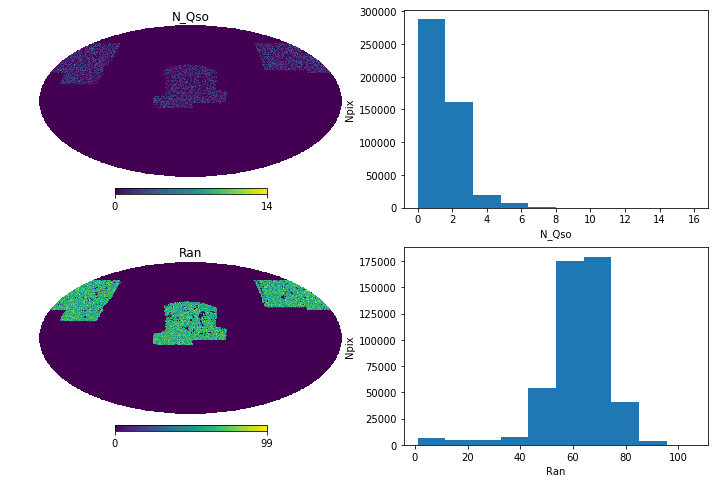

In [38]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
ax = ax.flatten()

cat = [galm, ranm]
ttl = ['N_Qso', 'Ran']
msk = ranm!=0.0
for i,ix in enumerate([0, 2]):
    catm = cat[i]
    plt.sca(ax[ix])
    print(np.median(catm[msk]))
    hp.mollview(catm, title=ttl[i], hold=True)
    plt.sca(ax[ix+1])
    ax[ix+1].hist(catm[msk])
    ax[ix+1].set_xlabel(ttl[i])
    ax[ix+1].set_ylabel('Npix')

In [39]:
fnames = ['sky_g',
          'sky_r',
          'sky_i',
          'sky_z',
          'airmass',
          'ebv',
          'depth_g',
          'depth_r',
          'depth_i',
          'depth_z',
          'psf_g',
          'psf_r',
          'psf_i',
          'psf_z',
          'w1_med',
          'w1_covmed',
          'w1_moon',
          'star_density']

#fnames
metadata = {'ngal':galm.astype('f8'), 'nran':ranm.astype('f8'), 'mask':ranm>0.0}
for fname_i in fnames:
    metadata[fname_i] = sdsswise[fname_i].astype('f8')
    
pdm = pd.DataFrame(metadata)
pdm.info()

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


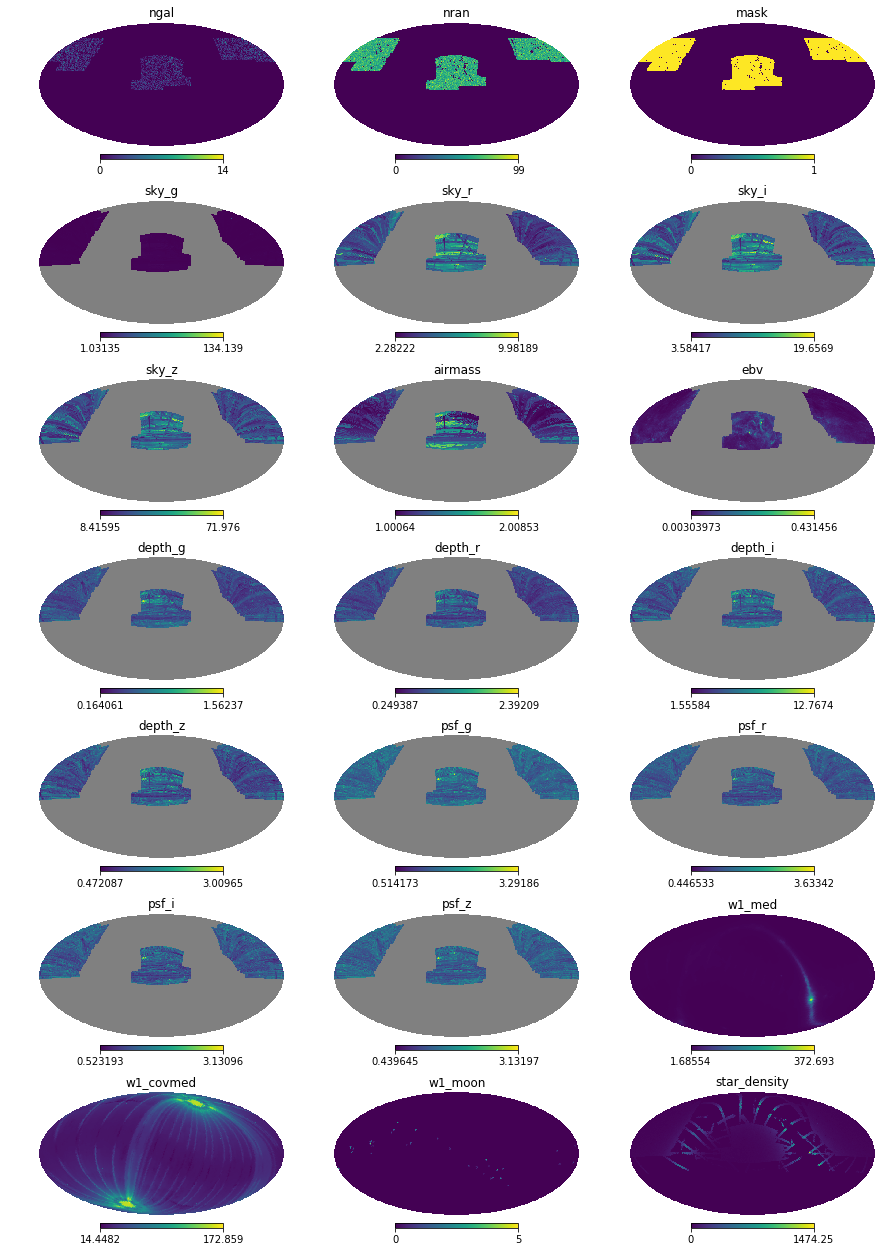

In [46]:
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(15, 22.4))
ax=ax.flatten()
for i,name in enumerate(pdm.columns):
    plt.sca(ax[i])
    hp.mollview(pdm[name], hold=True, title=name)

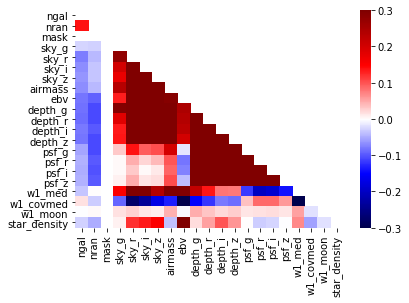

In [49]:
corr = pdm[pdm['mask']].corr()
mask = np.zeros_like(corr, '?')
mask[np.triu_indices_from(corr)] = True
sns.heatmap(corr, cmap=plt.cm.seismic, center=0, mask=mask, vmax=0.3, vmin=-0.3)

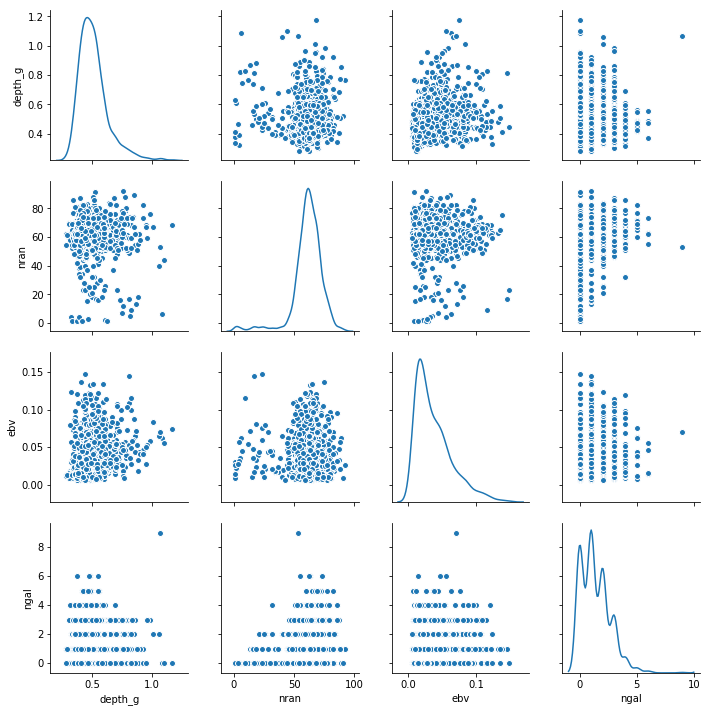

In [50]:
grid = sns.pairplot(pdm[pdm['mask']].sample(1000), 
            vars=[ 'depth_g','nran', 'ebv', 'ngal'], 
                   diag_kind='kde')

make masks for different footprints

writing ... /Volumes/TimeMachine/data/eboss/v4/mask_eboss21.hp256.fits
writing ... /Volumes/TimeMachine/data/eboss/v4/mask_eboss22.hp256.fits
writing ... /Volumes/TimeMachine/data/eboss/v4/mask_eboss23.hp256.fits
writing ... /Volumes/TimeMachine/data/eboss/v4/mask_eboss25.hp256.fits


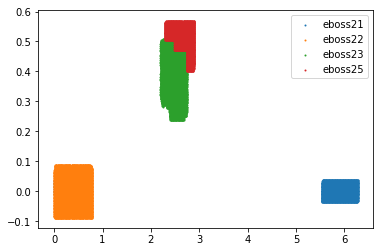

In [16]:
for i in [1, 2, 3, 5]:
    name  = 'eboss2'+str(i)
    nnam  = 'hpnrand_'+name
    maski = v4[nnam] > 0.0
    args  = np.argwhere(maski).flatten()
    thph  = hp.pix2ang(256, args)
    plt.scatter(thph[1], np.pi/2.-thph[0], label=name, s=1)
    nameo = ''.join((scratch,'eboss/v4/mask_', name ,'.hp256.fits'))
    print('writing ...', nameo)
    hp.write_map(nameo, maski, overwrite=True, dtype='f8', fits_IDL=False)
plt.legend()

Check the footprint

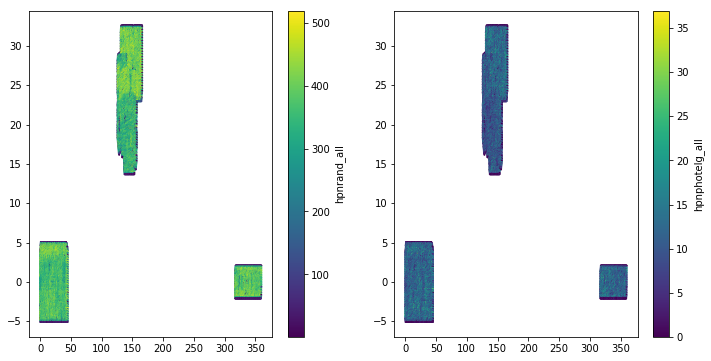

In [4]:
m = v4['hpnrand_all'] > 0.0
f,a = plt.subplots(ncols=2, figsize=(12, 6))
m1 = a[0].scatter(v4['hpra'][m], v4['hpdec'][m], s=1, c=v4['hpnrand_all'][m])
f.colorbar(m1, ax=a[0], label='hpnrand_all')
m2 = a[1].scatter(v4['hpra'][m], v4['hpdec'][m], s=1, c=v4['hpnphotelg_all'][m])
f.colorbar(m2, ax=a[1], label='hpnphotelg_all')

In [8]:
pdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786432 entries, 0 to 786431
Data columns (total 14 columns):
ngal              786432 non-null float64
nran              786432 non-null float64
mask              786432 non-null bool
hpgaiastardens    786432 non-null float64
hpebv             786432 non-null float64
hppsfdepth_r      786432 non-null float64
hppsfdepth_g      786432 non-null float64
hppsfdepth_z      786432 non-null float64
hpgaldepth_r      786432 non-null float64
hpgaldepth_g      786432 non-null float64
hpgaldepth_z      786432 non-null float64
hppsfsize_r       786432 non-null float64
hppsfsize_g       786432 non-null float64
hppsfsize_z       786432 non-null float64
dtypes: bool(1), float64(13)
memory usage: 78.8 MB


In [9]:
pd.read_hdf?

In [11]:
pde = pd.read_hdf('/Volumes/TimeMachine/data/DR7/DR7meta.h5')
pde.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786432 entries, 0 to 786431
Data columns (total 25 columns):
ccdskymag_g      196844 non-null float64
count_g          197583 non-null float64
exptime_g        197583 non-null float64
fwhm_g           197583 non-null float64
depth_g          197583 non-null float64
mjd_g            197583 non-null float64
ccdskymag_r      204684 non-null float64
count_r          206181 non-null float64
exptime_r        206181 non-null float64
fwhm_r           206181 non-null float64
depth_r          206181 non-null float64
mjd_r            206181 non-null float64
ccdskymag_z      211100 non-null float64
count_z          211822 non-null float64
exptime_z        211822 non-null float64
fwhm_z           211822 non-null float64
depth_z          211822 non-null float64
mjd_z            211822 non-null float64
nstar            786432 non-null float64
ebv              786432 non-null float64
ebv_lenz         786432 non-null float64
ebv_lenz_org     311592 non-

In [16]:
pde = pde[['debv_lenz_sfd', 'loghii']]
pde.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786432 entries, 0 to 786431
Data columns (total 2 columns):
debv_lenz_sfd    786432 non-null float64
loghii           786427 non-null float64
dtypes: float64(2)
memory usage: 18.0 MB


In [17]:
PD_combined = pd.concat([pde, pdm], axis=1)
PD_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786432 entries, 0 to 786431
Data columns (total 16 columns):
debv_lenz_sfd     786432 non-null float64
loghii            786427 non-null float64
ngal              786432 non-null float64
nran              786432 non-null float64
mask              786432 non-null bool
hpgaiastardens    786432 non-null float64
hpebv             786432 non-null float64
hppsfdepth_r      786432 non-null float64
hppsfdepth_g      786432 non-null float64
hppsfdepth_z      786432 non-null float64
hpgaldepth_r      786432 non-null float64
hpgaldepth_g      786432 non-null float64
hpgaldepth_z      786432 non-null float64
hppsfsize_r       786432 non-null float64
hppsfsize_g       786432 non-null float64
hppsfsize_z       786432 non-null float64
dtypes: bool(1), float64(15)
memory usage: 96.8 MB


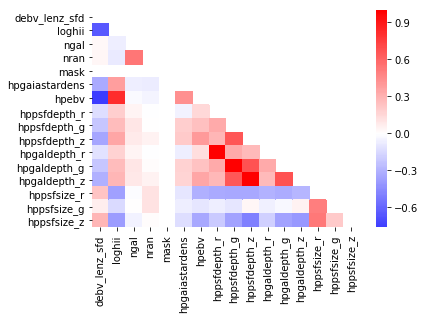

In [18]:
corr = PD_combined[PD_combined['mask']].corr()
mask = np.zeros_like(corr, '?')
mask[np.triu_indices_from(corr)] = True
sns.heatmap(corr, cmap=plt.cm.bwr, center=0, mask=mask)

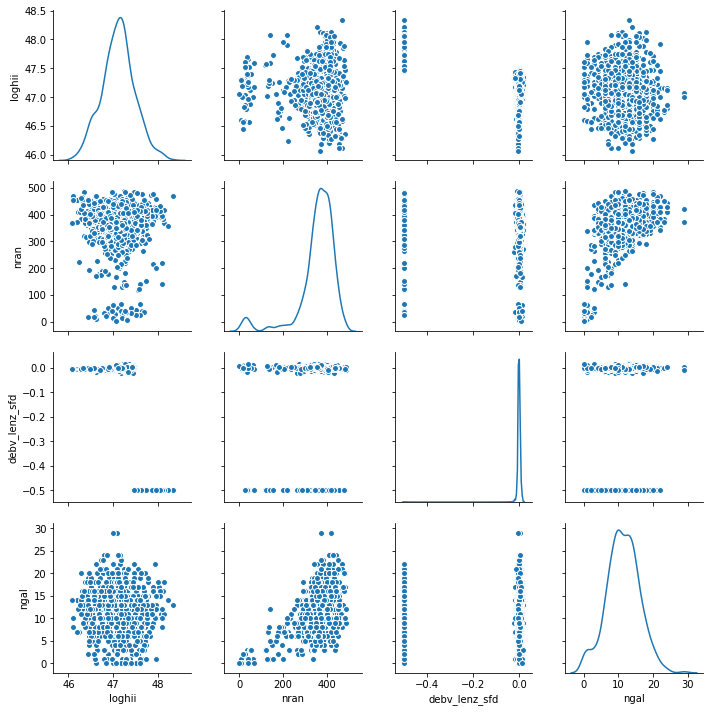

In [24]:
grid = sns.pairplot(PD_combined[PD_combined['mask']].sample(1000), 
            vars=[ 'loghii', 'nran', 'debv_lenz_sfd', 'ngal'], 
                   diag_kind='kde')

In [27]:
PD_combined.to_hdf(scratch+'/eboss/v4/ELG_hpsyst.hf', 'ELG_hpsyst', mode='w', format='fixed')

Split the data now

In [3]:
PD_combined = pd.read_hdf(scratch+'/eboss/v4/ELG_hpsyst.hf', mode='r')

In [4]:
mysample = PD_combined[PD_combined['mask']]
mysample.shape, mysample.describe()

((23191, 16),        debv_lenz_sfd        loghii          ngal          nran  \
 count   23191.000000  23191.000000  23191.000000  23191.000000   
 mean       -0.077759     47.110392     11.606960    358.268639   
 std         0.180915      0.354334      4.804556     84.249848   
 min        -0.500000     45.844031      0.000000      1.000000   
 25%        -0.005345     46.896109      8.000000    335.000000   
 50%        -0.001367     47.123680     11.000000    374.000000   
 75%         0.002037     47.329680     15.000000    408.500000   
 max         0.019557     48.415944     37.000000    519.000000   
 
        hpgaiastardens         hpebv  hppsfdepth_r  hppsfdepth_g  hppsfdepth_z  \
 count    23191.000000  23191.000000  23191.000000  23191.000000  23191.000000   
 mean       570.219398      0.035956    946.312516   1144.655029     92.761924   
 std        259.413001      0.018267   1332.198359    949.303508     68.890642   
 min        114.381897      0.011792     31.754353    

In [5]:
featnames = ['debv_lenz_sfd','loghii',
              'hpgaiastardens', 'hpebv',
              'hppsfdepth_r', 'hppsfdepth_g',
              'hppsfdepth_z', 'hpgaldepth_r',
              'hpgaldepth_g', 'hpgaldepth_z',
              'hppsfsize_r', 'hppsfsize_g',
              'hppsfsize_z']
maps = {'ngal':scratch+'eboss/v4/ELG.hp256.fits', 
        'nran':scratch+'eboss/v4/RAN.hp256.fits',
        'mask':scratch+'eboss/v4/mask.hp256.fits',
        'frac':scratch+'eboss/v4/fracgood.hp256.fits'}

def makehp(hpix, signal, res_out=256, ouname=None):
    mapo = np.zeros(12*res_out*res_out)
    mapo[hpix] = signal
    hp.write_map(ouname, mapo, fits_IDL=False, dtype='f8', overwrite=True)
    print('%s done!'%ouname)
    #return mapo

def pd2np(mysample, featnames=None, galname='ngal', 
          ranname='nran', fracname=None, maps=None): 
    # mysample_np = np.array(mysample.to_records().view(type=np.matrix))[0]
    hpix  = mysample.index.values
    ngal  = mysample.loc[:, galname].values
    nran  = mysample.loc[:, ranname].values
    nranm = nran.mean()
    frac  = nran / nranm  # fracgood
    label = np.zeros_like(ngal)
    sf    = ngal.sum()/ nran.sum()
    label = (ngal/ (nran*sf))
    
    feats = []
    for name in featnames:
        feats.append(mysample.loc[:, name].values)
    feats = np.array(feats).T

    data  = np.ones(hpix.size, dtype=np.dtype([('hpix','i8'), ('label', 'f8'), 
                                                ('features', 'f8', feats.shape[1]), ('fracgood', 'f8')]))
    for (a,b) in [(hpix, 'hpix'), (label, 'label'), 
                  (feats, 'features'), (frac, 'fracgood')]:
        data[b] = a

    makehp(hpix, ngal, ouname=maps['ngal'])
    makehp(hpix, nran, ouname=maps['nran'])
    makehp(hpix, 1.0,  ouname=maps['mask'])
    makehp(hpix, frac, ouname=maps['frac'])                
    return data

In [6]:
v4data = pd2np(mysample, featnames=featnames, maps=maps)

/Volumes/TimeMachine/data//eboss/v4/ELG.hp256.fits done!
/Volumes/TimeMachine/data//eboss/v4/RAN.hp256.fits done!
/Volumes/TimeMachine/data//eboss/v4/mask.hp256.fits done!
/Volumes/TimeMachine/data//eboss/v4/fracgood.hp256.fits done!


In [8]:
ft.write('/Volumes/TimeMachine/data//eboss/v4/ngal_features.fits', v4data, clobber=True)

In [9]:
v4r = split2Kfolds(v4data)

In [10]:
v4s = split2KfoldsSpatially(v4data)

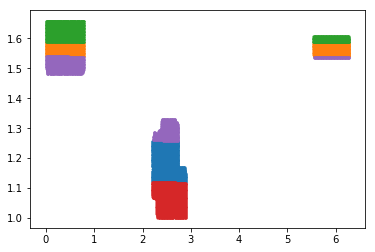

In [21]:
for l in v4s['test'].keys():
    thph = hp.pix2ang(256, v4s['test'][l]['hpix'])
    plt.scatter(thph[1], thph[0], s=1)
# plt.colorbar()

In [22]:
v4r['test']['fold0']['features'].shape

(4639, 13)

In [23]:
np.save('/Volumes/TimeMachine/data/eboss/v4/ELG.hp256.5.r', v4r)
np.save('/Volumes/TimeMachine/data/eboss/v4/ELG.hp256.5.s', v4s)